In [1]:
import pandas as pd

In [3]:
df = pd.read_csv('/Users/hallam/Documents/Housing/housing.csv')

In [4]:
df.head()

,Date,Facebook Cost,Bing Cost,Pinterest Cost,Google Cost,Transaction revenue
0,2019-06-09,33.15,20.67,20.67,544.64,3813.57
1,2019-06-10,31.04,30.47,30.47,509.05,2297.36
2,2019-06-11,30.81,18.33,18.33,528.21,4043.81
3,2019-06-12,31.34,26.65,26.65,453.44,11835.46
4,2019-06-13,65.68,29.49,29.49,1063.38,40308.30


In [5]:
df.isnull().values.any()

False

In [7]:
import seaborn as sns

<AxesSubplot:>

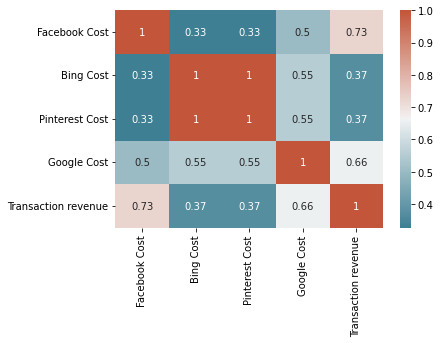

In [8]:
corr = df.corr()
sns.heatmap(
    corr, 
    xticklabels = corr.columns, 
    yticklabels = corr.columns, 
    annot = True, 
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
)

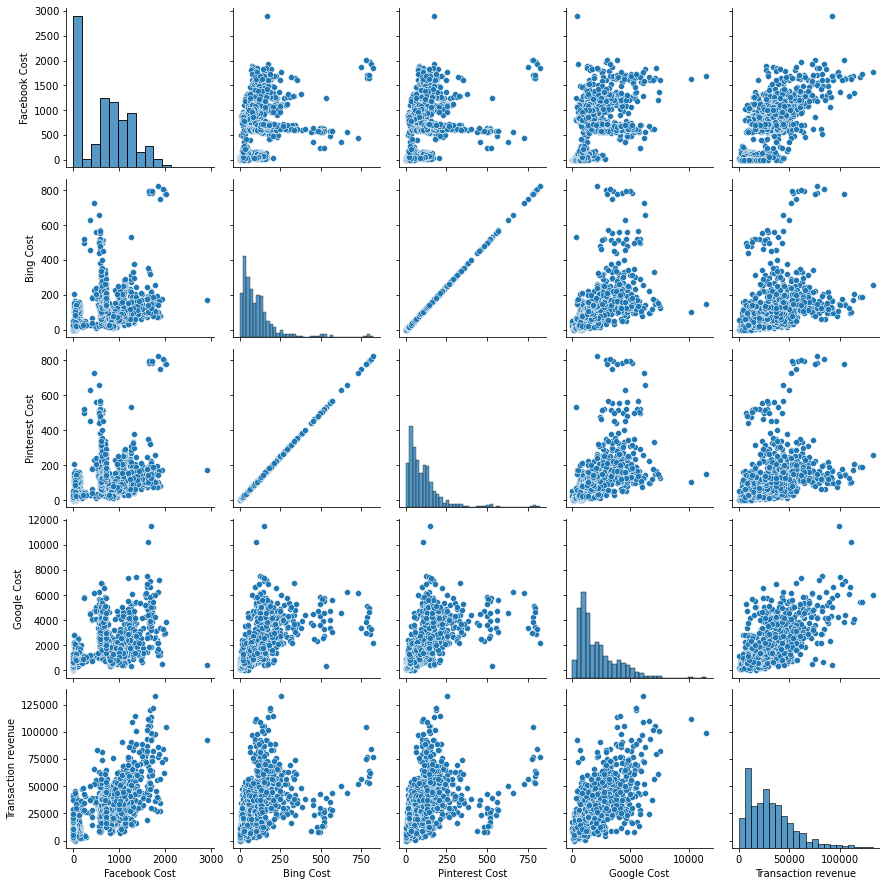

In [9]:
sns.pairplot(df)

### Feature Importance 

In [15]:
df.drop('Date', inplace=True, axis=1)

In [16]:
X = df.loc[:, df.columns != 'Transaction revenue']
y = df['Transaction revenue']

<AxesSubplot:>

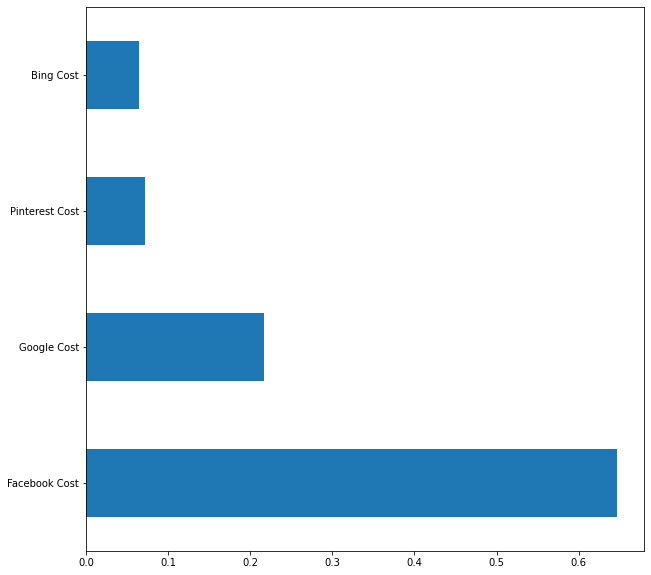

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)
model = RandomForestRegressor(random_state=1)
model.fit(X_train, y_train)
pred = model.predict(X_test)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh',figsize=(10,10))

### Contribution Plot

In [19]:
from sklearn.linear_model import LinearRegression

X = df.drop(columns=['Transaction revenue'])
y = df['Transaction revenue']

lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

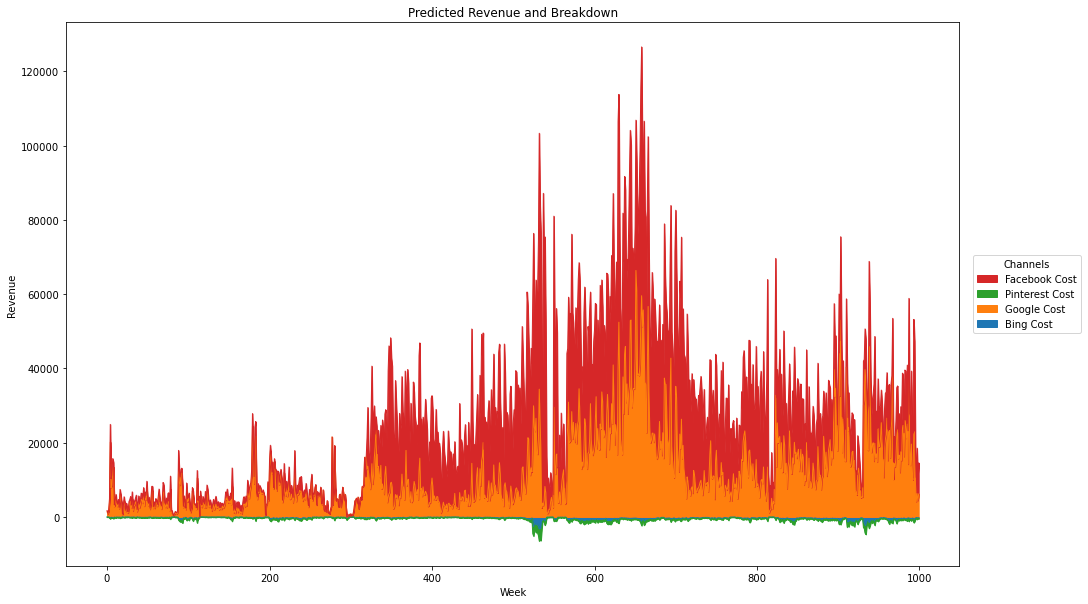

In [20]:
weights = pd.Series(
    lr.coef_,
    index=X.columns
)
base = lr.intercept_
unadj_contributions = X.mul(weights).assign(Base=base)
adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    ) # contains all contributions for each day
ax = (adj_contributions[['Bing Cost', 'Google Cost', 'Pinterest Cost', 'Facebook Cost']]
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Revenue and Breakdown',
          ylabel='Revenue',
          xlabel='Week')
     )
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)

### OLS Regression Model

In [23]:
df2 = df.rename(columns={"Bing Cost": "Bing", "Google Cost": "Google", "Pinterest Cost": "Pinterest", "Facebook Cost": "Facebook", "Transaction revenue": "Revenue"})

In [24]:
import statsmodels.formula.api as sm
model = sm.ols(formula="Revenue~Bing+Google+Pinterest+Facebook", data=df2).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Revenue   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.642
Method:                 Least Squares   F-statistic:                     598.4
Date:                Mon, 25 Apr 2022   Prob (F-statistic):          2.66e-222
Time:                        17:55:24   Log-Likelihood:                -10909.
No. Observations:                1000   AIC:                         2.183e+04
Df Residuals:                     996   BIC:                         2.185e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4819.6016    760.638      6.336      0.0

In [28]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [29]:
y_pred = model.predict()
labels = df2['Revenue']
df_temp = pd.DataFrame({'Actual': labels, 'Predicted':y_pred})
df_temp.head()

,Actual,Predicted
0,3813.57,8566.221205
1,2297.36,8263.062798
2,4043.81,8432.849405
3,11835.46,7970.821977
4,40308.30,12213.797140


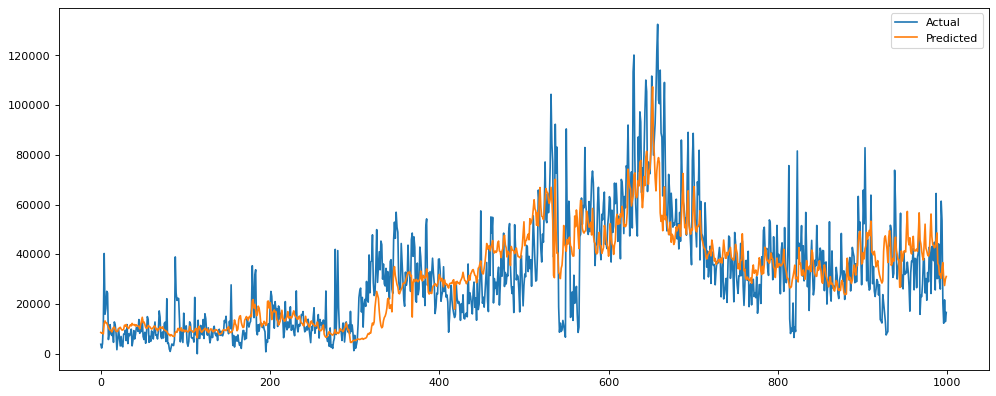

In [30]:
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
y1 = df_temp['Actual']
y2 = df_temp['Predicted']
plt.plot(y1, label = 'Actual')
plt.plot(y2, label = 'Predicted')
plt.legend()
plt.show()